# CNN for Fashion MNIST dataset

I have used Pytorch for this project, and also this is with some of the **Regularisation techniques**.

### Regularisation techniques:
1. Data Augmentation

2. Batch Normalisation

3. Dropout

### Regularisation Tips:
* It is Always good to train a model without Regularisation first and get a baseline for the model.

* Next you can use Regularisation techniques in order or one by one to improve model performance.





In [3]:
# Importing libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import PIL
import numpy as np

print(torch.cuda.is_available())

True


In [4]:
device = 'cuda'

In [5]:
# Data Augmentation
# We apply only Data Augmentation on training
data_transforms ={
    'train': transforms.Compose([
        transforms.RandomAffine(degrees = 10, translate = (0.05, 0.05), shear = 5),
        transforms.ColorJitter(hue = 0.05, saturation = 0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, interpolation = transforms.InterpolationMode.BILINEAR),
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ]),

    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
}



In [6]:
# Getting our Data
trainset = torchvision.datasets.FashionMNIST(
                                             root = './data',
                                             train=True,
                                             download=True,
                                             transform= data_transforms['train'])

testset = torchvision.datasets.FashionMNIST(root = './data',
                                             train=False,
                                             download=True,
                                             transform= data_transforms['val'])

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [7]:
# Data Loader

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size = 32,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size = 32,
    shuffle = False
)

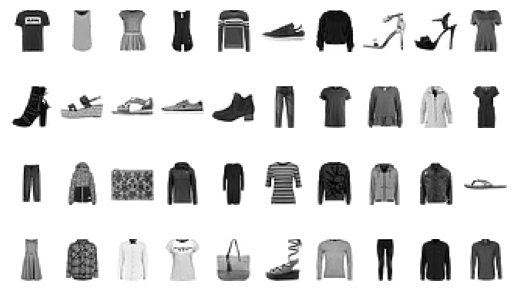

In [8]:
# Lets view our dataset
import matplotlib.pyplot as plt

figure = plt.figure()
no_images = 40

for i in range(1, no_images+1):
  plt.subplot(5, 10, i)
  plt.axis('off')
  plt.imshow(trainset.data[i], cmap = 'gray_r')

In [ ]:
# The CNN Structure

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv1_bn = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv2_bn = nn.BatchNorm2d(64)

    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(64*12*12, 128)
    self.fc2 = nn.Linear(128, 10)

    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.conv1_bn(self.conv1(x)))
    x = self.dropout(x)

    x = F.relu(self.conv2_bn(self.conv2(x)))
    x = self.dropout(x)

    x = self.pool(x)

    x = x.view(-1, 64*12*12)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x


cnn = CNN()
cnn.to(device)






CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# Optimizer and Loss

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
# Training the Model

epochs = 15

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
  print(f'Starting epoch no:{epoch+1}')

  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = cnn(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      correct = 0
      total = 0

      with torch.no_grad():
        for data in test_loader:
          images, labels = data

          images = images.to(device)
          labels = labels.to(device)

          outputs = cnn(images)

          _, pred = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        accuracy = 100*(correct/total)
        Current_epoch = epoch+1
        Current_loss = running_loss/50
        print(f'Epoch: {Current_epoch}, Loss: {Current_loss:.4f}, Test_Accuracy: {accuracy:.4f}%')
        running_loss = 0.0

  epoch_log.append(Current_epoch)
  loss_log.append(Current_loss)
  accuracy_log.append(accuracy)

print('The training has finished')




Starting epoch no:1
Epoch: 1, Loss: 1.1325, Test_Accuracy: 81.5300%
Epoch: 1, Loss: 1.1102, Test_Accuracy: 82.5900%
Epoch: 1, Loss: 1.1254, Test_Accuracy: 83.0700%
Epoch: 1, Loss: 1.0532, Test_Accuracy: 79.6400%
Epoch: 1, Loss: 1.0804, Test_Accuracy: 83.0600%
Epoch: 1, Loss: 1.0869, Test_Accuracy: 82.7000%
Epoch: 1, Loss: 1.0627, Test_Accuracy: 83.5300%
Epoch: 1, Loss: 1.0423, Test_Accuracy: 83.6500%
Epoch: 1, Loss: 1.0470, Test_Accuracy: 83.7100%
Epoch: 1, Loss: 0.9795, Test_Accuracy: 83.7000%
Epoch: 1, Loss: 0.9708, Test_Accuracy: 82.6300%
Epoch: 1, Loss: 0.9458, Test_Accuracy: 84.1000%
Epoch: 1, Loss: 1.0289, Test_Accuracy: 83.9400%
Epoch: 1, Loss: 1.0185, Test_Accuracy: 84.7000%
Epoch: 1, Loss: 0.9759, Test_Accuracy: 82.2200%
Epoch: 1, Loss: 0.9583, Test_Accuracy: 84.1000%
Epoch: 1, Loss: 0.9970, Test_Accuracy: 83.8000%
Epoch: 1, Loss: 0.9594, Test_Accuracy: 85.5000%
Starting epoch no:2
Epoch: 2, Loss: 0.9643, Test_Accuracy: 83.9200%
Epoch: 2, Loss: 0.9210, Test_Accuracy: 85.2700%


In [ ]:
# Saving our trained model inside a path
path = '/content/FashionMNIST-cnn.pth'
torch.save(cnn.state_dict(), path)

In [ ]:
# loading the saved model
# For loading the model you have to create the exact same CNN structure in a class
# And then make an instance of that class
# Since I already have that class in code above, I just need to make an instance

path ='/content/FashionMNIST-cnn.pth'

new_cnn = CNN()
cnn.to(device)

new_cnn.load_state_dict(torch.load(path))

<ipython-input-28-a89ac0594f2b>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_cnn.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
# Final Test Accuracy, Confusion matrix, Class_accuracy

from sklearn.metrics import confusion_matrix

correct = 0
total = 0

predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
labellist= torch.zeros(0, dtype = torch.long, device = 'cpu')

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)

        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

        predlist = torch.cat([predlist, pred.view(-1).cpu()])
        labellist = torch.cat([labellist, labels.view(-1).cpu()])

# Final Test Accuracy
accuracy = 100*(correct/total)
print(f'Final Test_Accuracy: {accuracy:.4f}%\n')

# Confusion matrix
conf_mat = confusion_matrix(labellist.numpy(), predlist.numpy())
print("Confusion matrix:")
print(conf_mat)

# Class_accuracy
class_accuracy = 100*(conf_mat.diagonal()/conf_mat.sum(1))
print("\nEach class accuracy:")
print(class_accuracy)

Final Test_Accuracy: 89.5700%

Confusion matrix:
[[798   1   8  19   2   1 165   0   5   1]
 [  3 977   0  15   0   0   3   0   2   0]
 [  8   0 805  10  85   0  91   0   1   0]
 [ 17   4   4 903  25   0  42   0   5   0]
 [  1   2  45  24 875   0  50   0   3   0]
 [  0   0   0   0   0 962   0  32   0   6]
 [ 88   2  46  19 103   0 731   0  11   0]
 [  0   0   0   0   0   3   0 959   0  38]
 [  2   0   4   2   1   2   3   5 981   0]
 [  0   0   0   0   0   3   0  30   1 966]]

Each class accuracy:
[79.8 97.7 80.5 90.3 87.5 96.2 73.1 95.9 98.1 96.6]
